<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



<font color='red'>**Задание:**</font> заполните код в этой тетрадке и выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
#PATH_TO_DATA = '~/capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [116]:
def prepare_train_set_with_shift(path_to_csv_files, sitesdat, session_length=10, shift_length = 10):
    files = os.listdir(path_to_csv_files)
    sites = []
    for j in range(1, session_length+1):
        sites.append('site' + str(j))
        sites.append('time_site'+str(j))
    #print(sites)
    res = []
    keyid = 1
    dats = []
    for afile in files:
        if 'user' in afile:
            fileid = int(afile[4:8])
            dat = pd.read_csv(path_to_csv_files + '\\' + afile)
            dat.timestamp = pd.to_datetime(dat.timestamp)
            dat['id'] = dat.index
            dat = dat.sort_values(['timestamp', 'id'])
            dat['fileid'] = fileid
            dats.append(dat)
    dat = pd.concat(dats, ignore_index=True)
    #print('joined data')
    
    #print(dat.head())
    #print(sitesdat.head())
    
    dat = dat.merge(sitesdat, left_on = 'site', right_on = 'site')
    #print('formed dictionary')
    #print(len(dat))
    for afileid in dat.fileid.unique():
        datred = dat[dat.fileid == afileid]
        #print(datred.head())
        datred = datred.sort_values(['timestamp_x', 'id'])
        datred.reset_index(drop = True, inplace = True)
        #print(afileid)
        mycols = []
        for j in range(session_length):
            if j < len(datred):
                acol = (datred.ix[j:len(datred):shift_length, 'keyid'].values).tolist()
                bcol = (pd.to_datetime(datred.ix[j:len(datred):shift_length, 'timestamp_x'].values)).tolist()
            else:
                acol = [0]
                bcol = [np.nan]
            if j==0:
                initlen = len(acol)
                mycols.append(acol)
                mycols.append((bcol))
            else: 
                if initlen > len(acol):
                    mycols.append(acol + [0]*(initlen-len(acol)))
                    mycols.append(bcol + [np.nan]*(initlen-len(acol)))
                else:
                    mycols.append(acol)
                    mycols.append((bcol))
        mycols.append([afileid]*initlen)
        tempres = pd.DataFrame(mycols).transpose()
        #print(tempres.head())
        #print(sites)
        tempres.columns = sites + ['user_id']
        res.append(tempres)
    res = pd.concat(res, ignore_index = True)
    res['session_id'] = res.index
    return(res, sitesdat)    


def prepare_train_set_with_fe(path_to_csv_files, site_freq_path,
                                    session_length=10, window_size=10):
    sitesdat = pd.read_csv(site_freq_path, sep = ';')
    dat = prepare_train_set_with_shift(path_to_csv_files, sitesdat, session_length, window_size)[0]
    dat['session_timespan'] = np.nan
    dat['#unique_sites'] = np.nan
    dat['start_hour'] = np.nan
    dat['day_of_week'] = np.nan
    sites = []
    times = []
    for j in range(1, session_length+1):
        sites.append('site' + str(j))
        times.append('time_site'+str(j))
    dattimes = dat[times]
    datsites = dat[sites]
    #print(dattimes.columns)
    for j in range(len(dat)):
        if j % 500 == 0:
            print(j)
        if (pd.isnull(dattimes.iloc[j, 0]) == False):
            astr = np.array(dattimes.iloc[[j]])
            astr = astr[~pd.isnull(astr)]
            mydiff = astr[len(astr)-1] - astr[0]
            #print(mydiff.days*86400 + mydiff.seconds)
            dat.loc[j, 'session_timespan'] = mydiff.days*86400 + mydiff.seconds
            astr = np.array(datsites.iloc[[j]])
            astr = astr[astr>0]
            dat.loc[j,'#unique_sites'] = (len(np.unique(astr)))
            dat.loc[j, 'start_hour'] = dattimes.iloc[j, 0].hour
            dat.loc[j, 'day_of_week'] = dattimes.iloc[j, 0].dayofweek            
    sites.append('session_timespan')
    sites.append('#unique_sites')
    sites.append('start_hour')
    sites.append('day_of_week')
    sites.append('user_id')
    return(dat[sites])
                    
    

In [117]:
sitesdat = pd.read_csv('sites3.csv', sep = ';')
dat3 = prepare_train_set_with_fe('D:/capstone_user_identification/3users/', 'sites3.csv', 10, 10)

0


In [113]:
hhh

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,4,2,2,9,2,1,7,6,8,10,7998.0,8.0,9.0,4.0,1
1,4,1,1,1,0,0,0,0,0,0,60.0,2.0,12.0,4.0,1
2,4,2,5,5,2,0,0,0,0,0,7935.0,3.0,9.0,4.0,2
3,3,1,2,1,2,1,1,6,11,3,7998.0,5.0,9.0,4.0,3
4,3,1,2,0,0,0,0,0,0,0,1471.0,3.0,12.0,4.0,3


**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [118]:
%%time
dat10 = prepare_train_set_with_fe('D:/capstone_user_identification/10users/', 'sites10.csv', 10, 10)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
Wall time: 25 s


In [119]:
dat10.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,193,586,133,3,133,133,3,133,204,133,33.0,5.0,8.0,4.0,31
1,421,192,675,254,133,31,398,3925,218,55,284.0,10.0,8.0,4.0,31
2,55,3,55,55,5,295,421,338,904,55,258.0,7.0,8.0,4.0,31
3,477,4731,477,55,55,55,55,976,199,123,30.0,6.0,8.0,4.0,31
4,342,55,5,3921,259,211,3818,2113,699,2113,6.0,9.0,8.0,4.0,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [120]:
%%time
dat150 = prepare_train_set_with_fe('D:/capstone_user_identification/150users/', 'sites150.csv', 10, 10)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [ ]:
new_features_10users = ''' ВАШ КОД ЗДЕСЬ '''
new_features_150users = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [121]:
dat10.session_timespan.median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [122]:
dat10.day_of_week.median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [123]:
dat150.start_hour.median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [124]:
dat150['#unique_sites'].median()

7.0

In [132]:
dat10['target'] = dat10.user_id
print(dat10.user_id.unique())

[31 33 39 50 100 127 128 207 237 241]


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [135]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
dat10['target'] = dat10['target'].map(id_name_dict)


In [136]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

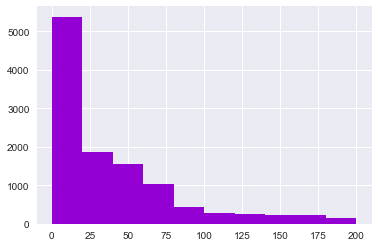

In [140]:
dat10[dat10.session_timespan <= 200]['session_timespan'].hist(color = "darkviolet")

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

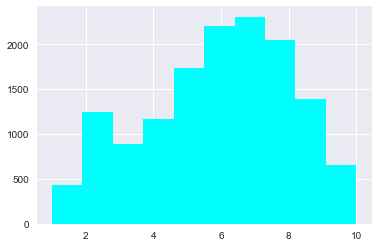

In [142]:
dat10['#unique_sites'].hist(color = 'aqua')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1


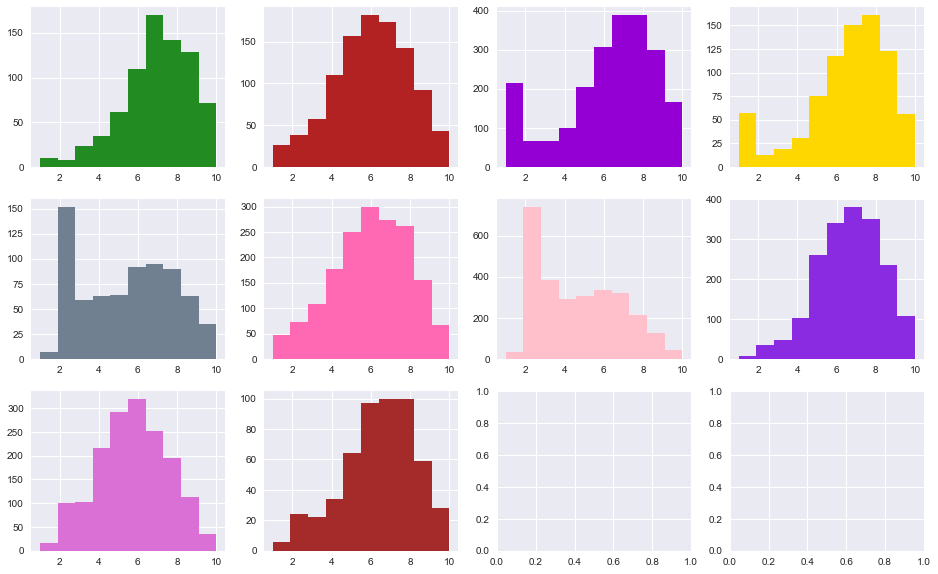

In [158]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(dat10, 'user_id')): 
     print(idx // 4, idx % 4)
     sub_df['#unique_sites'].hist(ax = axes[idx // 4, idx % 4], color = color_dic[id_name_dict[user]])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

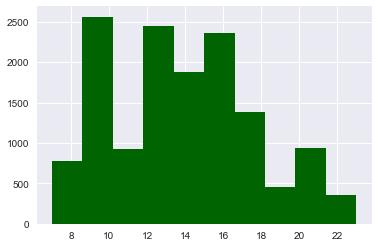

In [159]:
dat10['start_hour'].hist(color = 'darkgreen')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1


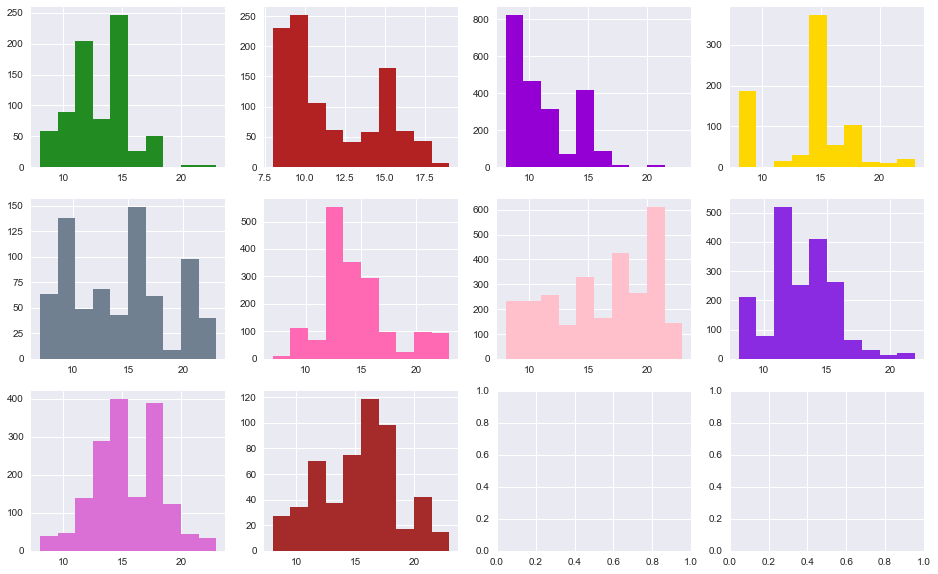

In [161]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(dat10, 'user_id')): 
     print(idx // 4, idx % 4)
     sub_df['start_hour'].hist(ax = axes[idx // 4, idx % 4], color = color_dic[id_name_dict[user]])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

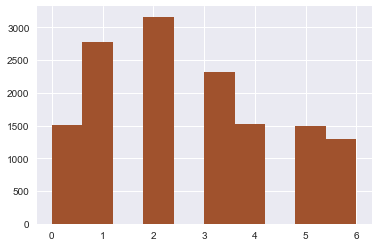

In [162]:
dat10['day_of_week'].hist(color = 'sienna')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

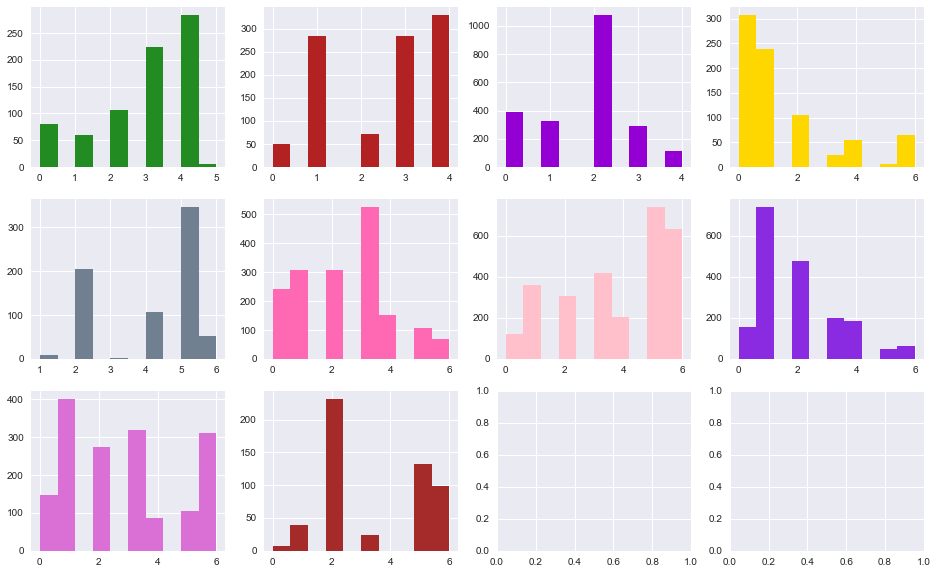

In [164]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(dat10, 'user_id')): 
     sub_df['day_of_week'].hist(ax = axes[idx // 4, idx % 4], color = color_dic[id_name_dict[user]])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [167]:
sites10 = pd.read_csv('sites10.csv', sep = ';')
sites10.head(10)

,index,site,timestamp,keyid
0,3101,s.youtube.com,8300,1
1,4175,www.google.fr,7813,2
2,4171,www.google.com,5441,3
3,2425,mail.google.com,4158,4
4,4103,www.facebook.com,4141,5
5,271,apis.google.com,3758,6
6,2976,r3---sn-gxo5uxg-jqbe.googlevideo.com,3244,7
7,2966,r1---sn-gxo5uxg-jqbe.googlevideo.com,3094,8
8,2888,plus.google.com,2630,9
9,139,accounts.google.com,2089,10


**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [ ]:
top10_freqs = ''' ВАШ КОД ЗДЕСЬ '''
top10_sites = ''' ВАШ КОД ЗДЕСЬ '''

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

                                    site  timestamp
0                          s.youtube.com       8300
1                          www.google.fr       7813
2                         www.google.com       5441
3                        mail.google.com       4158
4                       www.facebook.com       4141
5                        apis.google.com       3758
6   r3---sn-gxo5uxg-jqbe.googlevideo.com       3244
7   r1---sn-gxo5uxg-jqbe.googlevideo.com       3094
8                        plus.google.com       2630
9                    accounts.google.com       2089
10  r2---sn-gxo5uxg-jqbe.googlevideo.com       1939


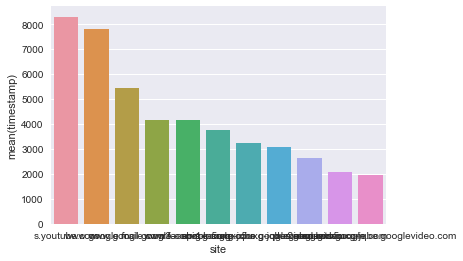

In [177]:
print(sites10.loc[0:10, ['site', 'timestamp']])
sns.barplot(x = 'site', y = 'timestamp', data = sites10.loc[0:10, ['site', 'timestamp']])

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

На следующей неделе мы наконец приступим к обучению моделей классификации. 